# Предсказание вида (аспекта) сербских глаголов
## _На материалах UD_Serbian-SET_
### Импорты, настройки, глобальные переменные

In [1]:
import pandas as pd
import csv
from pathlib import Path

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.model_selection import FeatureImportances

import numpy as np

import re

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
class Log:

    cols = ["experiment_name", "model_name", "F1_cv", "F1_wtd"]

    def __init__(self, fname: Path, sep: str):

        self.fname = fname
        self.sep = sep

        if not self.fname.exists():
            with open(fname, "w", encoding="utf-8") as file:
                file.write(self.sep.join(self.cols) + "\n")

    def write(self, vals):
        with open(self.fname, "a+", encoding="utf-8") as file:
            file.write(self.sep.join(vals) + "\n")

In [3]:
PAD_TOK = "[PAD]"
RANDOM_STATE = 42

DATAPATH = Path.cwd() / "data" / "datasetForAnalysis.csv"
LOGPATH = Path.cwd() / "data" / "models_results.csv"

SEP = "\t"

LOG = Log(LOGPATH, SEP)

%matplotlib inline
SNS_COLOR = "coolwarm"

torch.manual_seed(RANDOM_STATE)

import warnings
warnings.filterwarnings("ignore")

### Загрузка и подготовка датасета

In [4]:
df = pd.read_csv(
    DATAPATH,
    sep="\t",
    quoting=csv.QUOTE_NONE,
    index_col=0,
    dtype=str
)

In [5]:
df = df.drop(["POS", "db_id"], axis=1)

In [6]:
df = df.fillna(PAD_TOK)

In [7]:
# Нет нулей
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4959 entries, 0 to 4958
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   lemma          4959 non-null   object
 1   word           4959 non-null   object
 2   aspect         4959 non-null   object
 3   disambig       4959 non-null   object
 4   text           4959 non-null   object
 5   Gender         4959 non-null   object
 6   Mood           4959 non-null   object
 7   Number         4959 non-null   object
 8   Person         4959 non-null   object
 9   Tense          4959 non-null   object
 10  VerbForm       4959 non-null   object
 11  Voice          4959 non-null   object
 12  l_tok_3        4959 non-null   object
 13  l_tok_2        4959 non-null   object
 14  l_tok_1        4959 non-null   object
 15  r_tok_1        4959 non-null   object
 16  r_tok_2        4959 non-null   object
 17  r_tok_3        4959 non-null   object
 18  l_gr_1         4959 non-null   ob

In [8]:
# 311 лемм
df.nunique()

lemma             311
word             1451
aspect              3
disambig            3
text             2605
Gender              4
Mood                3
Number              3
Person              4
Tense               4
VerbForm            3
Voice               2
l_tok_3          2048
l_tok_2          2060
l_tok_1          1611
r_tok_1          1550
r_tok_2          2330
r_tok_3          2267
l_gr_1             21
l_gr_2             25
l_gr_3             28
r_gr_1              7
r_gr_2             24
r_gr_3             25
nsubj              91
nsubj_count         2
obj                54
obj_count           2
obl               141
obl_count           5
advmod             52
advmod_count        4
polarity            2
polarity_word      10
dtype: int64

In [9]:
target_vars = [
    "aspect",
    "disambig",
]

dict_vars = [
    "lemma",
    "word",
]

grapheme_vars = [
    "l_gr_1",
    "l_gr_2",
    "l_gr_3",
    "r_gr_1",
    "r_gr_2",
    "r_gr_3",
]

grammar_vars = [
    "Gender",
    "Mood",
    "Number",
    "Person",
    "Tense",
    "VerbForm",
    "Voice",
    "nsubj_count",
    "obj_count",
    "obl_count",
    "advmod_count",
    "polarity",
]

text_vars = [
    "lemma",
    "word",
    "text",
    "l_tok_3",
    "l_tok_2",
    "l_tok_1",
    "r_tok_1",
    "r_tok_2",
    "r_tok_3",
    "nsubj",
    "obj",
    "obl",
    "advmod",
    "polarity_word",
]

In [10]:
X = df.drop(target_vars, axis=1)
y = df[target_vars]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    shuffle=True
)

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3967, 32), (992, 32), (3967, 2), (992, 2))

In [13]:
def plot_freqs(df, col):
    counts = df[col].value_counts().reset_index()

    plt.figure(figsize=(12, 5))
    sns.barplot(
        data=counts.iloc[:min(counts.shape[0], 20)],
        x=col,
        y="count",
        palette=SNS_COLOR
    )
    plt.xticks(rotation=30)
    plt.title(f"{col.capitalize()} Counts")
    plt.tight_layout()
    plt.show()

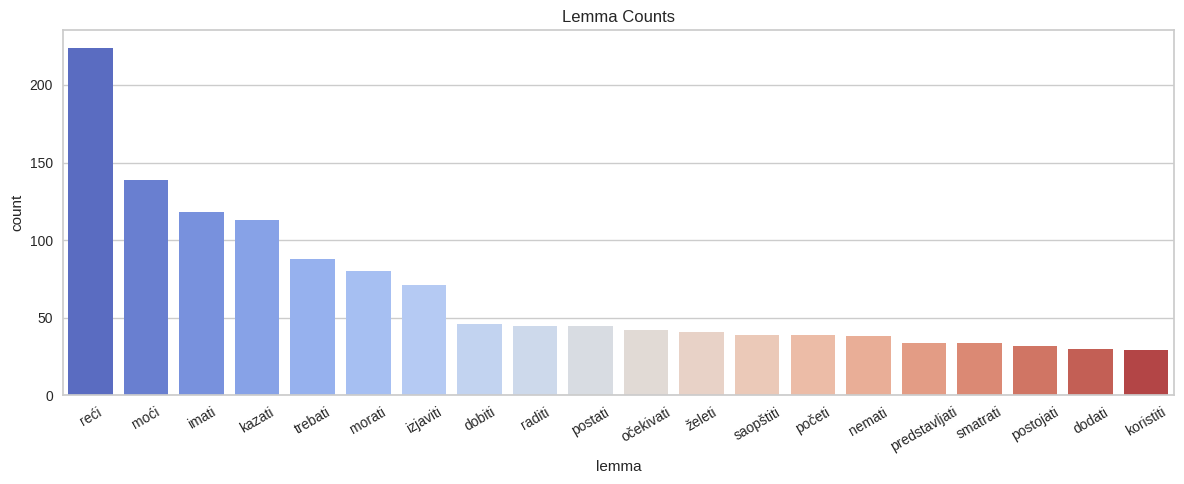

In [14]:
plot_freqs(X_train, "lemma")

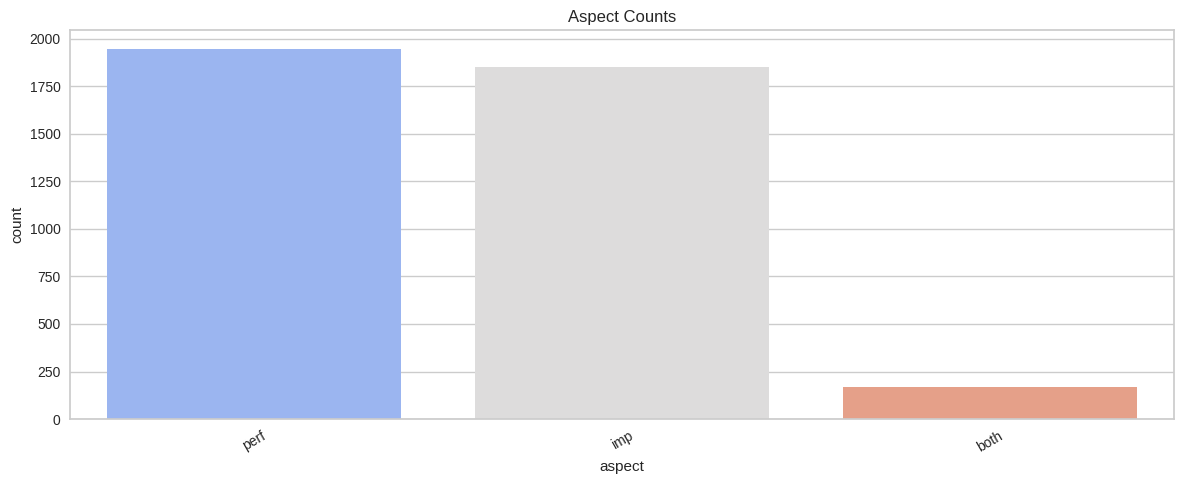

In [15]:
plot_freqs(y_train, "aspect")

In [16]:
X_train_resample = X_train.merge(
    y_train,
    left_index=True,
    right_index=True
).groupby(
    "lemma",
    group_keys=False
).apply(
    lambda elem: elem.sample(
        n=20,
        replace=True if len(elem) < 50 else False
    )
).reset_index(drop=True)

In [17]:
y_train_resample = X_train_resample[["aspect", "disambig"]]
X_train_resample = X_train_resample.drop(["aspect", "disambig"], axis=1)

In [18]:
X_train_resample.shape, y_train_resample.shape

((6220, 32), (6220, 2))

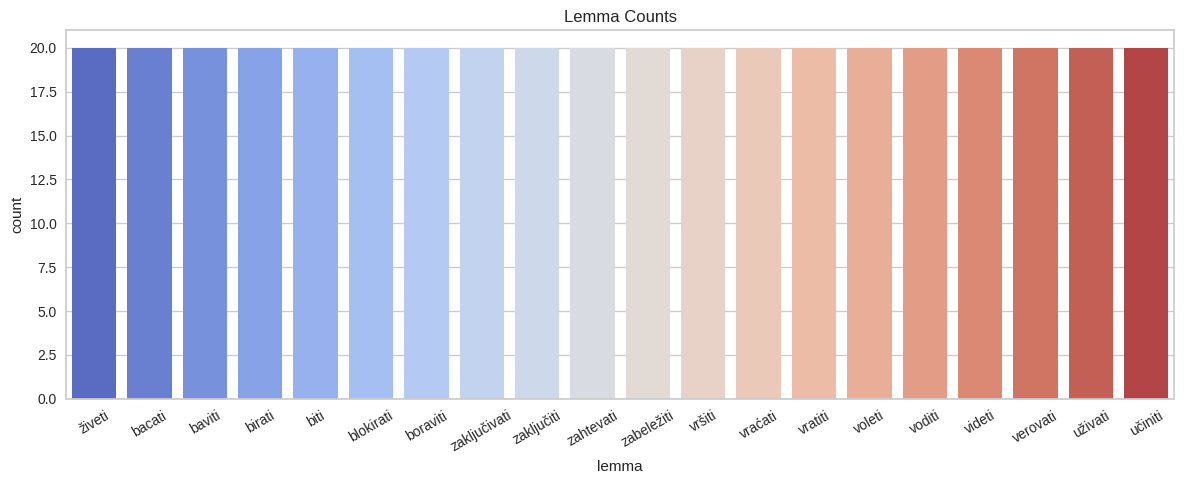

In [19]:
plot_freqs(X_train_resample, "lemma")

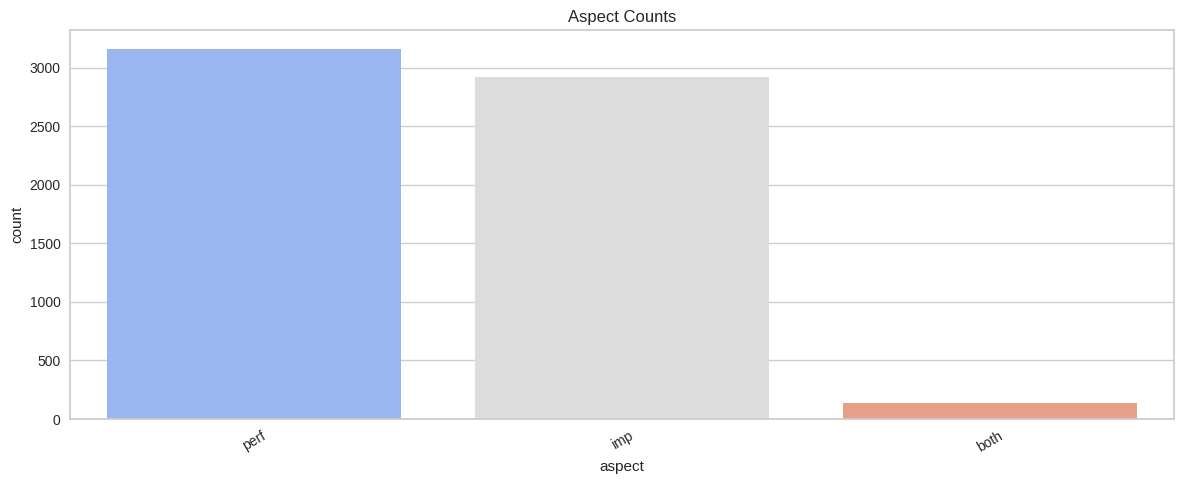

In [20]:
plot_freqs(y_train_resample, "aspect")

### Вспомогательные функции

In [21]:
def plot_corr(X: pd.DataFrame):

    X_cpy = X.copy(deep=True)

    label_encoder = LabelEncoder()
    for column in X_cpy.columns:
        X_cpy[column] = label_encoder.fit_transform(X_cpy[column])

    corr= X_cpy.corr()

    plt.figure(figsize=(8,6))
    sns.heatmap(
        corr,
        mask=np.abs(corr) < 0.33,
        annot=True,
        fmt=".2f",
        cmap=SNS_COLOR,
        vmin=-1,
        vmax=1
    )
    plt.title("Correlation Matrix")
    plt.show()

In [22]:
def one_hot_encode(X_train, X_test):

    X_train_cpy = X_train.copy(deep=True)
    X_test_cpy = X_test.copy(deep=True)

    encoder = OneHotEncoder(handle_unknown='warn', sparse_output=False)

    pandas_columns = X_train_cpy.columns

    X_train_cpy = pd.DataFrame(encoder.fit_transform(X_train_cpy))
    X_test_cpy  = pd.DataFrame(encoder.transform(X_test_cpy))

    new_columns = encoder.get_feature_names_out(pandas_columns)
    new_columns = [re.sub(r'\[|\]', '_', col) for col in new_columns]

    X_train_cpy.columns = new_columns
    X_test_cpy.columns = new_columns

    return X_train_cpy, X_test_cpy

In [23]:
def experiment(experiment_name, get_model, X_train, X_test, y_train, y_test, log=LOG, report=False, fi=False):

    model = get_model()
    model_name = model.__class__.__name__

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    cv_scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv=KFold(
            n_splits=10,
            shuffle=True,
            random_state=RANDOM_STATE
        ),
        scoring="f1_weighted"
    )

    confusions = confusion_matrix(y_test, preds)

    cv_f1 = np.mean(cv_scores)
    f1_wtd = f1_score(y_test, preds, average="weighted")

    to_print = [
        f"\n--- {experiment_name}: {model_name} ---\n",
        f"CV F1: {cv_f1:.3f}",
        f"F1 weighted: {f1_wtd:.3f}",
        confusions,
    ]

    if report:
        report = classification_report(
            y_test,
            preds,
            zero_division=1.0
        )
        to_print.append(report)

    list(
        map(lambda string: print(string, "\n"), to_print)
    )

    if fi:
        viz = FeatureImportances(model, relative=False, topn=25)
        viz.fit(X_train, y_train)
        viz.show()

    if log is not None:
        log.write(
            [
                experiment_name,
                model_name,
                str(np.round(cv_f1, decimals=3)),
                str(np.round(f1_wtd, decimals=3))
            ]
        )

### Модели

In [24]:
get_regression = lambda: LogisticRegression(max_iter=200)
get_lgbm = lambda: LGBMClassifier(random_state=RANDOM_STATE, verbose=-1)
get_dt = lambda: DecisionTreeClassifier(random_state=RANDOM_STATE)
get_nn = lambda: MLPClassifier(hidden_layer_sizes=(100, 50, 25), alpha=0.0001, max_iter=200)

### Эксперименты графемами

In [25]:
X_train_graphemes = X_train[grapheme_vars]
X_train_resample_graphemes = X_train_resample[grapheme_vars]
X_test_graphemes = X_test[grapheme_vars]

X_train_graphemes.head()

,l_gr_1,l_gr_2,l_gr_3,r_gr_1,r_gr_2,r_gr_3
4448,u,s,r,a,l,i
1204,m,i,s,m,i,l
80,d,a,t,i,t,a
803,i,z,j,o,i,v
1769,o,b,e,u,j,u


In [26]:
X_train_graphemes_2 = X_train_graphemes.drop(["l_gr_3", "r_gr_3"], axis=1)
X_train_resample_graphemes_2 = X_train_resample_graphemes.drop(["l_gr_3", "r_gr_3"], axis=1)
X_test_graphemes_2 = X_test_graphemes.drop(["l_gr_3", "r_gr_3"], axis=1)

X_train_graphemes_2.head()

,l_gr_1,l_gr_2,r_gr_1,r_gr_2
4448,u,s,a,l
1204,m,i,m,i
80,d,a,i,t
803,i,z,o,i
1769,o,b,u,j


In [27]:
X_train_graphemes_1 = X_train_graphemes_2.drop(["l_gr_2", "r_gr_2"], axis=1)
X_train_resample_graphemes_1 = X_train_resample_graphemes_2.drop(["l_gr_2", "r_gr_2"], axis=1)
X_test_graphemes_1 = X_test_graphemes_2.drop(["l_gr_2", "r_gr_2"], axis=1)

X_train_graphemes_1.head()

,l_gr_1,r_gr_1
4448,u,a
1204,m,m
80,d,i
803,i,o
1769,o,u


In [28]:
X_train_sufs = pd.DataFrame()
X_train_resample_sufs = pd.DataFrame()
X_test_sufs = pd.DataFrame()

X_train_sufs["pref"] = X_train_graphemes["l_gr_1"] + X_train_graphemes["l_gr_2"] + X_train_graphemes["l_gr_3"]
X_train_sufs["suf"] = X_train_graphemes["r_gr_1"] + X_train_graphemes["r_gr_2"] + X_train_graphemes["r_gr_3"]

X_train_resample_sufs["pref"] = X_train_resample_graphemes["l_gr_1"] + X_train_resample_graphemes["l_gr_2"] + X_train_resample_graphemes["l_gr_3"]
X_train_resample_sufs["suf"] = X_train_resample_graphemes["r_gr_1"] + X_train_resample_graphemes["r_gr_2"] + X_train_resample_graphemes["r_gr_3"]

X_test_sufs["pref"] = X_test_graphemes["l_gr_1"] + X_test_graphemes["l_gr_2"] + X_test_graphemes["l_gr_3"]
X_test_sufs["suf"] = X_test_graphemes["r_gr_1"] + X_test_graphemes["r_gr_2"] + X_test_graphemes["r_gr_3"]

X_train_sufs.head()

,pref,suf
4448,usr,ali
1204,mis,mil
80,dat,ita
803,izj,oiv
1769,obe,uju


In [29]:
X_train_sufs.nunique()

pref    217
suf     262
dtype: int64

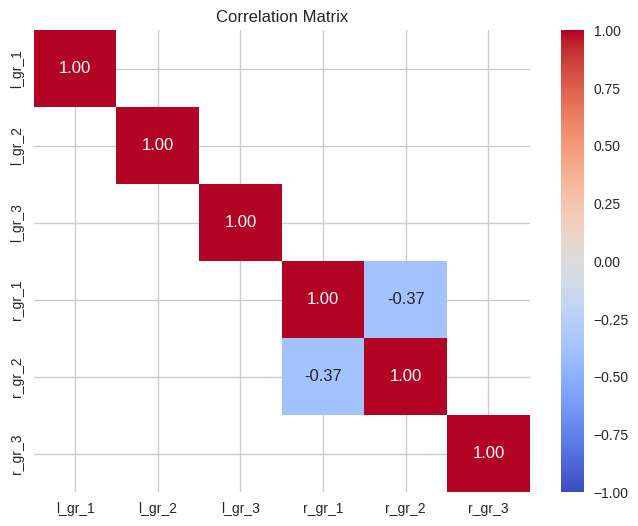

In [30]:
plot_corr(X_train_graphemes)

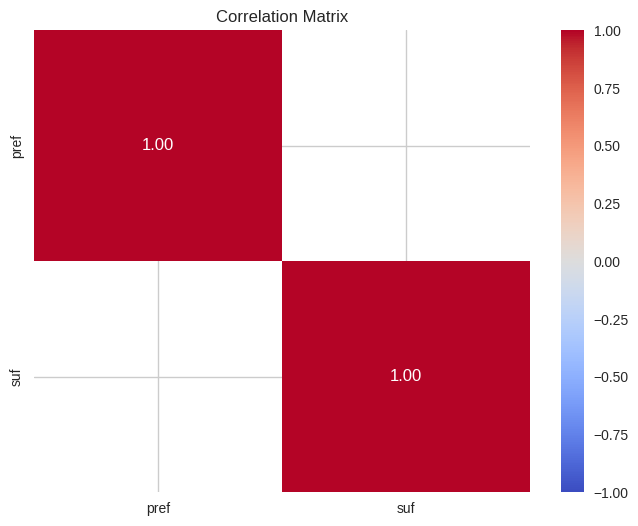

In [31]:
plot_corr(X_train_sufs)

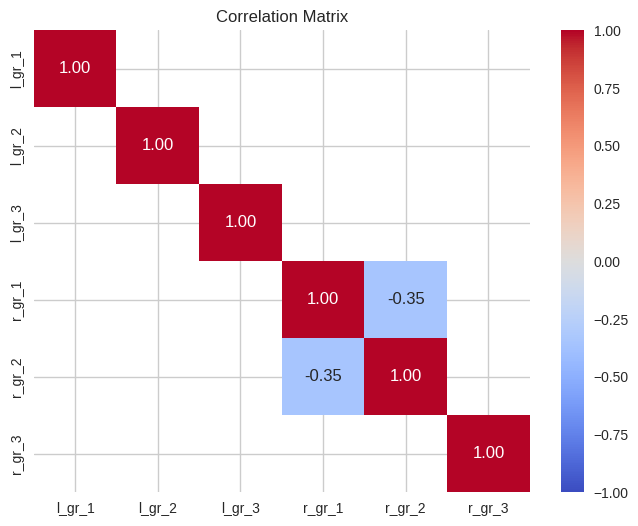

In [32]:
plot_corr(X_train_resample_graphemes)

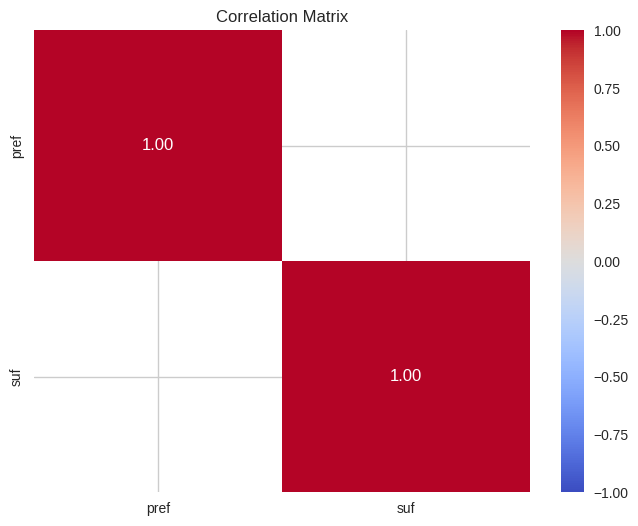

In [33]:
plot_corr(X_train_resample_sufs)

In [34]:
X_train_graphemes_oh, X_test_graphemes_oh = one_hot_encode(
    X_train_graphemes,
    X_test_graphemes,
)

In [35]:
X_train_resample_graphemes_oh, X_test_resample_graphemes_oh = one_hot_encode(
    X_train_resample_graphemes,
    X_test_graphemes,
)

In [36]:
X_train_sufs_oh, X_test_sufs_oh = one_hot_encode(
    X_train_sufs,
    X_test_sufs,
)

In [37]:
X_train_resample_sufs_oh, X_test_resample_sufs_oh = one_hot_encode(
    X_train_resample_sufs,
    X_test_sufs,
)

In [38]:
X_train_graphemes_2_oh, X_test_graphemes_2_oh = one_hot_encode(
    X_train_graphemes_2,
    X_test_graphemes_2
)

In [39]:
X_train_resample_graphemes_2_oh, X_test_resample_graphemes_2_oh = one_hot_encode(
    X_train_resample_graphemes_2,
    X_test_graphemes_2,
)

In [40]:
X_train_graphemes_1_oh, X_test_graphemes_1_oh = one_hot_encode(
    X_train_graphemes_1,
    X_test_graphemes_1
)

In [41]:
X_train_resample_graphemes_1_oh, X_test_resample_graphemes_1_oh = one_hot_encode(
    X_train_resample_graphemes_1,
    X_test_graphemes_1,
)

In [42]:
models = [get_regression, get_lgbm, get_dt]
# models = [get_regression, get_lgbm, get_dt, get_nn]

In [43]:
experiments = [
    lambda model: experiment(
        "all_graphemes",
        model,
        X_train_graphemes_oh,
        X_test_graphemes_oh,
        y_train["aspect"],
        y_test["aspect"]
    ),
    lambda model: experiment(
        "sufs",
        model,
        X_train_sufs_oh,
        X_test_sufs_oh,
        y_train["aspect"],
        y_test["aspect"]
    ),
    lambda model: experiment(
        "2_graphemes",
        model,
        X_train_graphemes_2_oh,
        X_test_graphemes_2_oh,
        y_train["aspect"],
        y_test["aspect"]
    ),
    lambda model: experiment(
        "1_grapheme",
        model,
        X_train_graphemes_1_oh,
        X_test_graphemes_1_oh,
        y_train["aspect"],
        y_test["aspect"]
    ),
    lambda model: experiment(
        "all_graphemes_resample",
        model,
        X_train_resample_graphemes_oh,
        X_test_resample_graphemes_oh,
        y_train_resample["aspect"],
        y_test["aspect"]
    ),
    lambda model: experiment(
        "sufs_resample",
        model,
        X_train_resample_sufs_oh,
        X_test_resample_sufs_oh,
        y_train_resample["aspect"],
        y_test["aspect"]
    ),
    lambda model: experiment(
        "2_graphemes_resample",
        model,
        X_train_resample_graphemes_2_oh,
        X_test_resample_graphemes_2_oh,
        y_train_resample["aspect"],
        y_test["aspect"]
    ),
    lambda model: experiment(
        "1_grapheme_resample",
        model,
        X_train_resample_graphemes_1_oh,
        X_test_resample_graphemes_1_oh,
        y_train_resample["aspect"],
        y_test["aspect"]
    ),
]

In [44]:
for e in experiments:
    for model in models:
        e(model)


--- all_graphemes: LogisticRegression ---
 

CV F1: 0.887 

F1 weighted: 0.885 

[[ 35   5   1]
 [  0 405  61]
 [  1  46 438]] 


--- all_graphemes: LGBMClassifier ---
 

CV F1: 0.967 

F1 weighted: 0.965 

[[ 41   0   0]
 [  0 441  25]
 [  0  10 475]] 


--- all_graphemes: DecisionTreeClassifier ---
 

CV F1: 0.950 

F1 weighted: 0.948 

[[ 41   0   0]
 [  0 436  30]
 [  0  22 463]] 


--- sufs: LogisticRegression ---
 

CV F1: 0.948 

F1 weighted: 0.951 

[[ 39   1   1]
 [  0 438  28]
 [  0  19 466]] 


--- sufs: LGBMClassifier ---
 

CV F1: 0.829 

F1 weighted: 0.820 

[[ 30   6   5]
 [  3 332 131]
 [  1  30 454]] 


--- sufs: DecisionTreeClassifier ---
 

CV F1: 0.961 

F1 weighted: 0.959 

[[ 40   1   0]
 [  0 443  23]
 [  0  17 468]] 


--- 2_graphemes: LogisticRegression ---
 

CV F1: 0.860 

F1 weighted: 0.854 

[[ 34   3   4]
 [  0 395  71]
 [  2  65 418]] 


--- 2_graphemes: LGBMClassifier ---
 

CV F1: 0.917 

F1 weighted: 0.924 

[[ 40   1   0]
 [  0 420  46]
 [  1  27 457

In [45]:
model_scores_df = pd.read_csv(LOGPATH, sep="\t")
model_scores_df.head()

,experiment_name,model_name,F1_cv,F1_wtd
0,all_graphemes,LogisticRegression,0.887,0.885
1,all_graphemes,LGBMClassifier,0.967,0.965
2,all_graphemes,DecisionTreeClassifier,0.950,0.948
3,sufs,LogisticRegression,0.948,0.951
4,sufs,LGBMClassifier,0.829,0.820


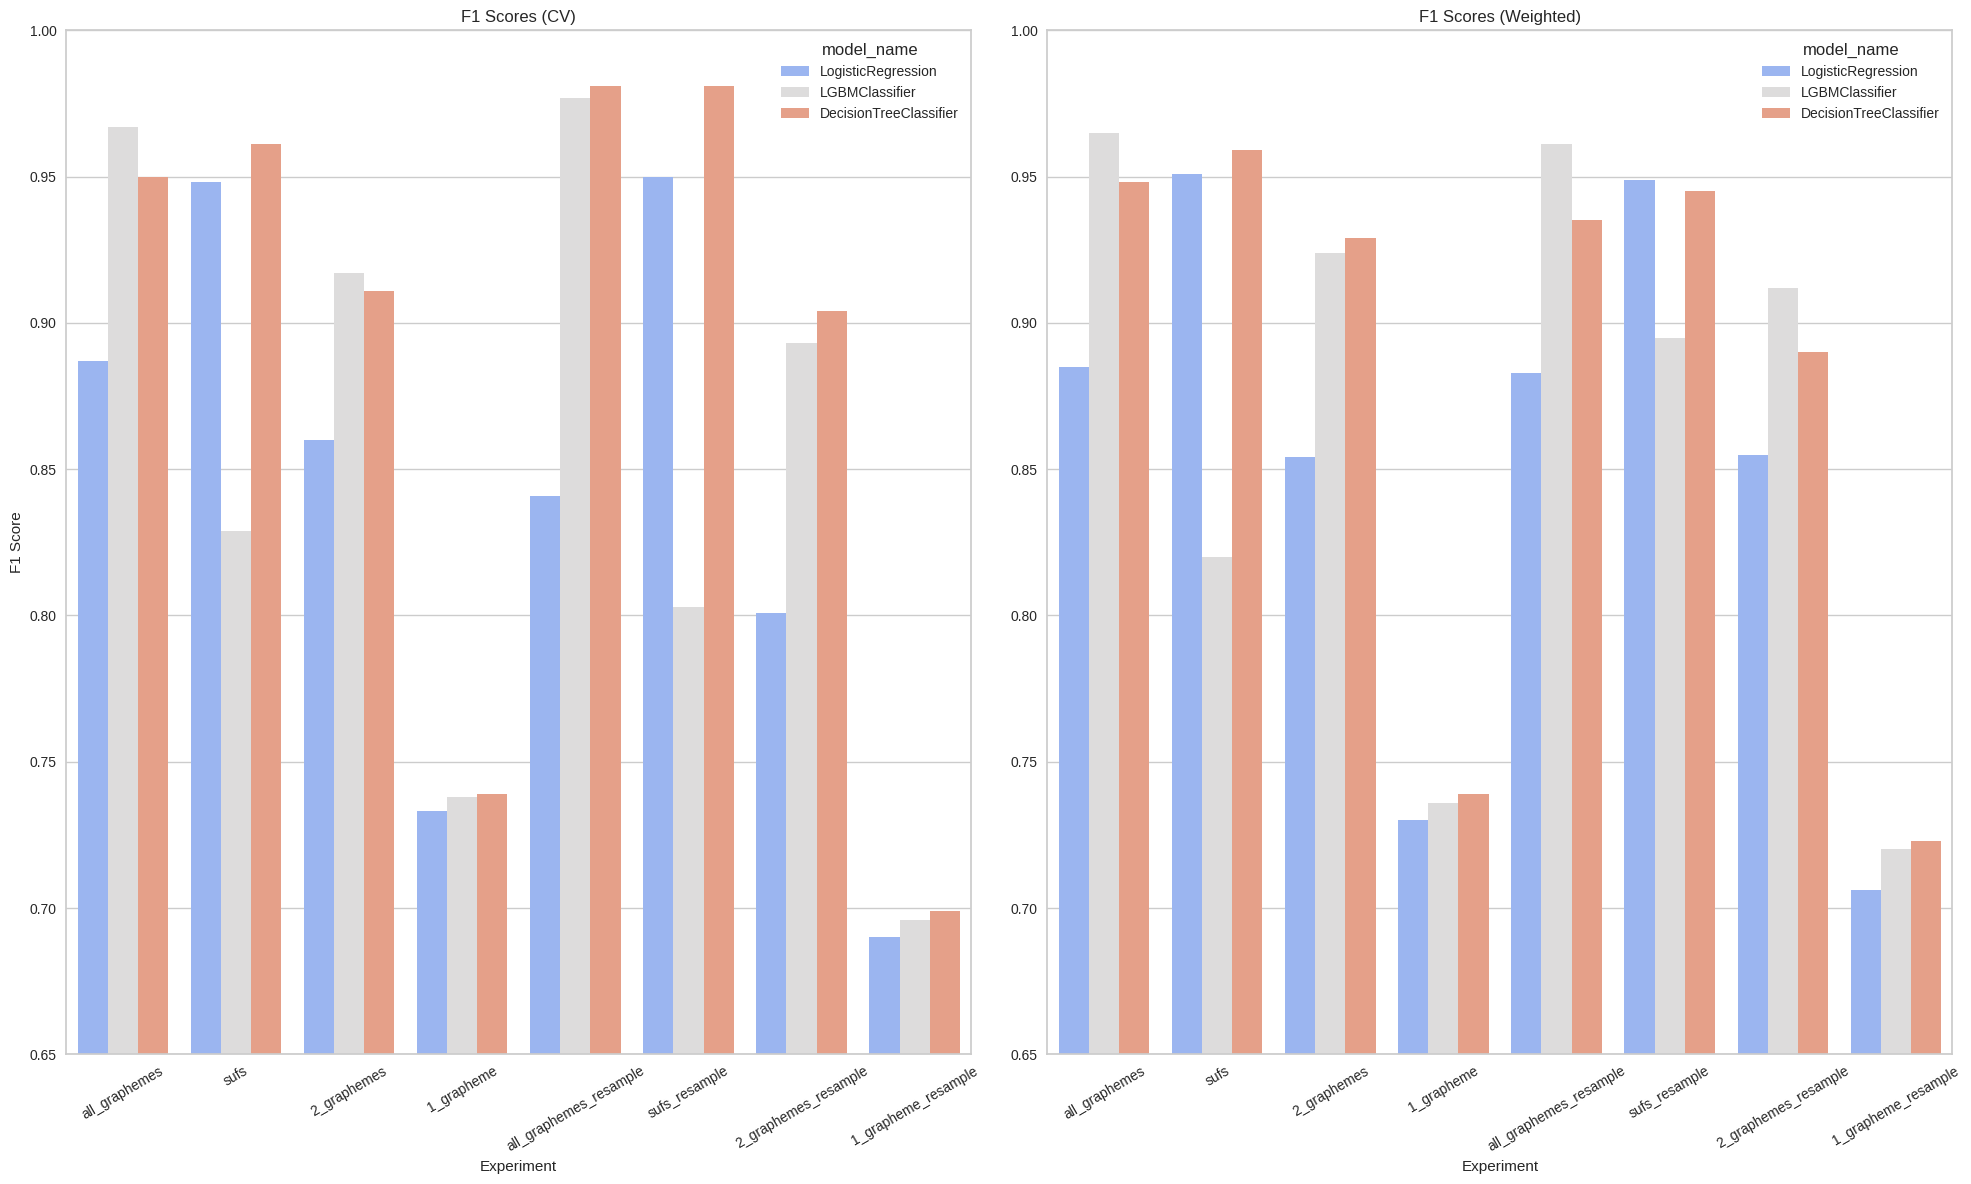

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))

sns.barplot(
    data=model_scores_df,
    x="experiment_name",
    y="F1_cv",
    hue="model_name",
    palette=SNS_COLOR,
    errorbar=None,
    ax=ax1  # Assign to first subplot
)
ax1.set_title("F1 Scores (CV)")
ax1.set_xlabel("Experiment")
ax1.set_ylabel("F1 Score")
ax1.set_ylim(0.65, 1.0)
ax1.tick_params(axis='x', rotation=30)

sns.barplot(
    data=model_scores_df,
    x="experiment_name",
    y="F1_wtd",
    hue="model_name",
    palette=SNS_COLOR,
    errorbar=None,
    ax=ax2  # Assign to second subplot
)
ax2.set_title("F1 Scores (Weighted)")
ax2.set_xlabel("Experiment")
ax2.set_ylabel("")  # Hide duplicate y-label
ax2.set_ylim(0.65, 1.0)
ax2.tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

In [61]:
model_scores_df.loc[model_scores_df["F1_cv"].idxmax()]

experiment_name    all_graphemes_resample
model_name         DecisionTreeClassifier
F1_cv                               0.981
F1_wtd                              0.935
Name: 14, dtype: object

In [62]:
model_scores_df.loc[model_scores_df["F1_wtd"].idxmax()]

experiment_name     all_graphemes
model_name         LGBMClassifier
F1_cv                       0.967
F1_wtd                      0.965
Name: 1, dtype: object


--- BEST GRAPHEMES CV: DecisionTreeClassifier ---
 

CV F1: 0.981 

F1 weighted: 0.945 

[[ 40   1   0]
 [  0 439  27]
 [  0  27 458]] 

              precision    recall  f1-score   support

        both       1.00      0.98      0.99        41
         imp       0.94      0.94      0.94       466
        perf       0.94      0.94      0.94       485

    accuracy                           0.94       992
   macro avg       0.96      0.95      0.96       992
weighted avg       0.94      0.94      0.94       992
 



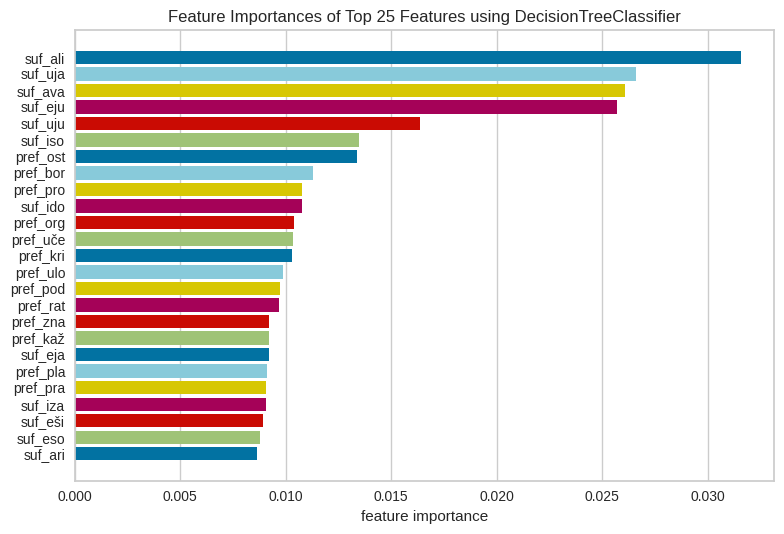

In [64]:
experiment(
    "BEST GRAPHEMES CV",
    get_dt,
    X_train_resample_sufs_oh,
    X_test_resample_sufs_oh,
    y_train_resample["aspect"],
    y_test["aspect"],
    log=None,
    report=True,
    fi=True
)


--- BEST GRAPHEMES Weighted: LGBMClassifier ---
 

CV F1: 0.967 

F1 weighted: 0.965 

[[ 41   0   0]
 [  0 441  25]
 [  0  10 475]] 

              precision    recall  f1-score   support

        both       1.00      1.00      1.00        41
         imp       0.98      0.95      0.96       466
        perf       0.95      0.98      0.96       485

    accuracy                           0.96       992
   macro avg       0.98      0.98      0.98       992
weighted avg       0.97      0.96      0.96       992
 



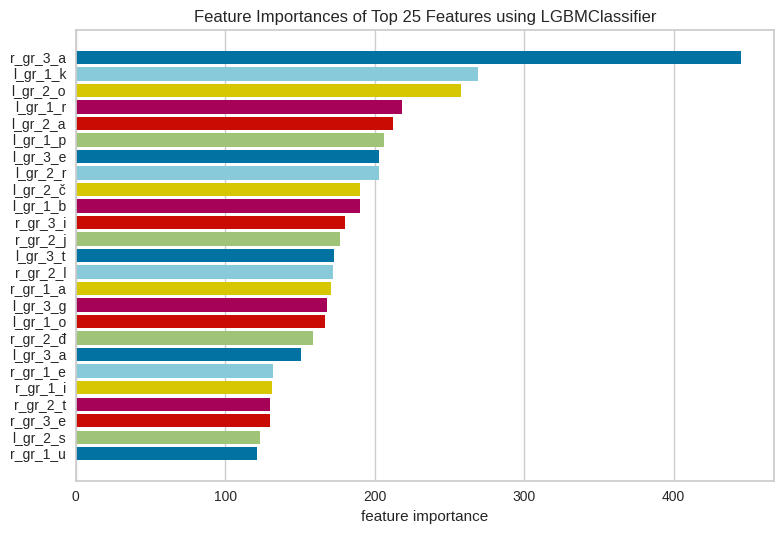

In [63]:
experiment(
    "BEST GRAPHEMES Weighted",
    get_lgbm,
    X_train_graphemes_oh,
    X_test_graphemes_oh,
    y_train["aspect"],
    y_test["aspect"],
    log=None,
    report=True,
    fi=True
)